In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing import image
import tensorflow as tf

import numpy as np
import scipy

In [2]:
tf.__version__

'1.14.0'

In [3]:
K.set_learning_phase(0)

In [4]:
model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False)

W1223 09:38:19.616544 140437412968256 deprecation.py:506] From /home/cleanpegasus/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5':1.5,
}

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [7]:
layer_dict

{'input_1': <tensorflow.python.keras.engine.input_layer.InputLayer at 0x7fb9d4fe3590>,
 'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fb9d504dd90>,
 'batch_normalization': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7fba1c4fce10>,
 'activation': <tensorflow.python.keras.layers.core.Activation at 0x7fb9d4fab490>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fb9d4fabfd0>,
 'batch_normalization_1': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7fb9d4f8dc50>,
 'activation_1': <tensorflow.python.keras.layers.core.Activation at 0x7fb9d4f29b10>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fb9d4f29dd0>,
 'batch_normalization_2': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7fb9d4eeef10>,
 'activation_2': <tensorflow.python.keras.layers.core.Activation at 0x7fb9d4f0cf90>,
 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D at

In [8]:
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2 : -2, 2: -2, :])) / scaling

In [9]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]

In [10]:
fetch_loss_and_grads = K.function([dream], outputs)

In [11]:
def eval_loss_and_grads(x):
    
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    
    return loss_value, grad_values

In [12]:
def gradient_ascent(x, iterations, step, max_loss=None):
    
    for i in range(iterations):
        
        loss_value, grad_values = eval_loss_and_grads(x)
        
        if max_loss is not None and loss_value > max_loss:
            break
            
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
        
    return x

In [13]:
def resize_img(img, size):
    
    img = np.copy(img)
    
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    
    return scipy.ndimage.zoom(img, factors, order=1)

In [14]:
def preprocess_image(image_path):

    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    
    return img

In [15]:
def deprocess_image(x):

    if K.image_data_format() == 'channels_first':
        
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
        
    else:
        
        x = x.reshape((x.shape[1], x.shape[2], 3))
        
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
def save_img(img, fname):
    
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

In [ ]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10

base_image_path = 'musk.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
    
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[: :-1]
    
original_img = np.copy(img)

shrunk_original_image = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    
    print('Processing image shape ', shape)
    
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations = iterations, step = step, max_loss = max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_image, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img = img + lost_detail
    shrunk_original_image = resize_img(original_img, shape)
    
    #save_img(img, fname = 'dream_at_scale_' + str(shape) + '.png')
    
save_img(img, fname = 'dream_image_' + str(base_image_path[:-4]) + '.png')
    

Processing image shape  (1360, 2040)
...Loss value at 0 : 1.3786798
...Loss value at 1 : 1.914726
...Loss value at 2 : 2.6593926
...Loss value at 3 : 3.4761407
...Loss value at 4 : 4.3162313
...Loss value at 5 : 5.149589
...Loss value at 6 : 5.9680595
...Loss value at 7 : 6.773496
...Loss value at 8 : 7.566787
...Loss value at 9 : 8.339022
...Loss value at 10 : 9.089914
...Loss value at 11 : 9.820507
Processing image shape  (1905, 2857)


/home/cleanpegasus/.local/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


...Loss value at 0 : 3.4567354
...Loss value at 1 : 5.0978136
...Loss value at 2 : 6.3416214
...Loss value at 3 : 7.3981166
...Loss value at 4 : 8.390452
...Loss value at 5 : 9.30928
Processing image shape  (2667, 4000)


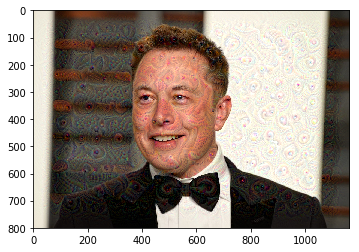

In [21]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()